### LOAD DATA

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [41]:
import pandas as pd
final_df = pd.read_csv("/Users/keithteo/Desktop/ATAP Sem/BT4222/Notebooks/final_df.csv")

### MODEL

In [47]:
# @title v5 (additional features)
class MCNN_Precomputed(nn.Module):
    def __init__(self):
        super(MCNN_Precomputed, self).__init__()

        # Projections for existing features (text, image, readability, etc.)
        self.text_proj = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.LayerNorm(512)
        )

        self.image_proj = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.LayerNorm(512)
        )

        self.readability_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        self.ela_proj = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.LayerNorm(128)
        )

        self.sentiment_proj = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.LayerNorm(64)
        )

        self.similarity_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        # Projections for additional features
        self.avg_word_count_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        self.avg_word_length_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        self.score_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        # Attention layers
        self.text_attention = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)
        self.image_attention = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)

        # Cross-modal attention
        self.text_to_image_attn = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)
        self.image_to_text_attn = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)

        # Feedforward after attention
        self.text_ffn = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.image_ffn = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.text_norm = nn.LayerNorm(512)
        self.image_norm = nn.LayerNorm(512)

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 + 512 + 128 + 64 + 16 * 5, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2)
        )

    def forward(self, bert_emb, cnn_emb, readability_features, ela_features, sentiment_features, avg_word_count, avg_word_length, score):
        # Projections for existing features
        text_feat = self.text_proj(bert_emb)
        img_feat = self.image_proj(cnn_emb)
        readability_feat = self.readability_proj(readability_features.view(-1, 1))
        ela_feat = self.ela_proj(ela_features)
        sentiment_feat = self.sentiment_proj(sentiment_features)
        sim_feat = self.similarity_proj(F.cosine_similarity(text_feat, img_feat, dim=1).unsqueeze(1))

        # Projections for additional features
        avg_word_count_feat = self.avg_word_count_proj(avg_word_count.view(-1, 1))
        avg_word_length_feat = self.avg_word_length_proj(avg_word_length.view(-1, 1))
        score_feat = self.score_proj(score.view(-1, 1))

        # Add sequence dimension for attention
        text_seq = text_feat.unsqueeze(1)
        img_seq = img_feat.unsqueeze(1)

        text_attn_out, _ = self.text_attention(text_seq, text_seq, text_seq)
        text_attn = self.text_norm(text_attn_out + self.text_ffn(text_attn_out))
        img_attn_out, _ = self.image_attention(img_seq, img_seq, img_seq)
        img_attn = self.image_norm(img_attn_out + self.image_ffn(img_attn_out))

        # Remove sequence dimension
        text_attn_out = text_attn_out.squeeze(1)
        img_attn_out = img_attn_out.squeeze(1)

        # Concatenation
        combined = torch.cat([
            text_attn_out, img_attn_out, readability_feat, ela_feat, sentiment_feat, sim_feat,
            avg_word_count_feat, avg_word_length_feat, score_feat
        ], dim=1)

        logits = self.classifier(combined)
        return logits


def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    best_val_acc = 0.0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for bert, cnn, read, ela, sentiment, avg_word_count, avg_word_length, score, labels in tqdm(train_loader):
            # Move the data to the correct device (e.g., 'cuda' or 'cpu')
            bert, cnn, read, ela, sentiment, avg_word_count, avg_word_length, score, labels = (
                bert.to(device), cnn.to(device), read.to(device), ela.to(device), sentiment.to(device),
                avg_word_count.to(device), avg_word_length.to(device), score.to(device), labels.to(device)
            )

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(bert, cnn, read, ela, sentiment, avg_word_count, avg_word_length, score)

            # Calculate the loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track the running loss and accuracy
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        # Calculate training accuracy
        train_acc = correct / total

        # Validate the model
        val_acc = evaluate(model, val_loader, device)

        # Print training and validation stats
        print(f"Train Loss: {running_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_mcnn_model.pth")
            plateau_count = 0
        else:
            plateau_count += 1

        # Early stopping to prevent overfitting
        if plateau_count >= 5:
            print("Early stopping triggered")
            break
def evaluate(model, dataloader, device):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for bert, cnn, read, ela, sentiment, avg_word_count, avg_word_length, score, labels in dataloader:
            # Move the data to the correct device (e.g., 'cuda' or 'cpu')
            bert, cnn, read, ela, sentiment, avg_word_count, avg_word_length, score, labels = (
                bert.to(device), cnn.to(device), read.to(device), ela.to(device), sentiment.to(device),
                avg_word_count.to(device), avg_word_length.to(device), score.to(device), labels.to(device)
            )

            # Forward pass
            outputs = model(bert, cnn, read, ela, sentiment, avg_word_count, avg_word_length, score)

            # Get predictions and compute accuracy
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    # Return accuracy
    return correct / total

### TRAIN VAL TEST SET

In [49]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import ast

# Initial train/test split
train_df, temp_df = train_test_split(final_df, test_size=0.2, stratify=final_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

class MCNNDataset(Dataset):
    def __init__(self, dataframe):
        # Text and image embeddings
        self.bert = torch.tensor(dataframe['bert_embeddings'].apply(ast.literal_eval).tolist(), dtype=torch.float32)
        self.cnn = torch.tensor(dataframe['cnn_embeddings'].apply(ast.literal_eval).tolist(), dtype=torch.float32)

        # Readability score
        self.read = torch.tensor(dataframe['readability_score'].values, dtype=torch.float32)

        # ELA features
        self.ela = torch.tensor(dataframe[['ela_std', 'ela_max', 'ela_entropy']].values, dtype=torch.float32)

        # Sentiment features
        self.sentiment = torch.tensor(dataframe[['vader_neu', 'vader_compound']].values, dtype=torch.float32)

        # Additional features
        self.avg_word_count = torch.tensor(dataframe['text_length'].values, dtype=torch.float32)  # New feature
        self.avg_word_length = torch.tensor(dataframe['avg_word_length'].values, dtype=torch.float32)  # New feature
        self.score = torch.tensor(dataframe['score'].values, dtype=torch.float32)  # New feature

        # Labels
        self.labels = torch.tensor(dataframe['label'].values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            self.bert[idx], self.cnn[idx], self.read[idx], self.ela[idx], self.sentiment[idx],
            self.avg_word_count[idx], self.avg_word_length[idx], self.score[idx], self.labels[idx]
        )
# Instantiate datasets
train_dataset = MCNNDataset(train_df)
val_dataset = MCNNDataset(val_df)
test_dataset = MCNNDataset(test_df)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate model and move to device
model = MCNN_Precomputed().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Using device: cpu


In [53]:
train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=20)


Epoch 1/20


100%|█████████████████████████████████████████| 365/365 [00:05<00:00, 66.48it/s]


Train Loss: 193.6305 | Train Acc: 0.7154 | Val Acc: 0.7930

Epoch 2/20


100%|█████████████████████████████████████████| 365/365 [00:05<00:00, 69.83it/s]


Train Loss: 138.1302 | Train Acc: 0.8129 | Val Acc: 0.8040

Epoch 3/20


100%|█████████████████████████████████████████| 365/365 [00:05<00:00, 65.56it/s]


Train Loss: 121.3085 | Train Acc: 0.8404 | Val Acc: 0.8280

Epoch 4/20


100%|█████████████████████████████████████████| 365/365 [00:05<00:00, 69.69it/s]


Train Loss: 110.0082 | Train Acc: 0.8524 | Val Acc: 0.8382

Epoch 5/20


100%|█████████████████████████████████████████| 365/365 [00:05<00:00, 70.42it/s]


Train Loss: 99.6319 | Train Acc: 0.8689 | Val Acc: 0.8293

Epoch 6/20


100%|█████████████████████████████████████████| 365/365 [00:05<00:00, 65.21it/s]


Train Loss: 91.9871 | Train Acc: 0.8780 | Val Acc: 0.8314

Epoch 7/20


100%|█████████████████████████████████████████| 365/365 [00:07<00:00, 48.20it/s]


Train Loss: 85.8460 | Train Acc: 0.8841 | Val Acc: 0.8184

Epoch 8/20


100%|█████████████████████████████████████████| 365/365 [00:10<00:00, 33.69it/s]


Train Loss: 80.2182 | Train Acc: 0.8937 | Val Acc: 0.8232

Epoch 9/20


100%|█████████████████████████████████████████| 365/365 [00:09<00:00, 40.36it/s]


Train Loss: 74.8524 | Train Acc: 0.9008 | Val Acc: 0.8307
Early stopping triggered


In [ ]:
# v1, with just raw features
class MCNN_Precomputed(nn.Module):
    def __init__(self):
        super(MCNN_Precomputed, self).__init__()

        # Initial projections
        self.text_proj = nn.Linear(768, 512)
        self.image_proj = nn.Linear(2048, 512)
        self.ela_proj = nn.Linear(4, 128)
        self.similarity_proj = nn.Linear(1, 64)

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 + 512 + 128 + 64, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )

    def forward(self, bert_emb, cnn_emb, ela_features):
        # Projections
        text_feat = self.text_proj(bert_emb)       # (B, 512)
        img_feat = self.image_proj(cnn_emb)        # (B, 512)
        ela_out = self.ela_proj(ela_features)      # (B, 128)

        # Cosine similarity
        sim = F.cosine_similarity(text_feat, img_feat, dim=1).unsqueeze(1)
        sim_out = self.similarity_proj(sim)

        # Fusion
        combined = torch.cat([text_feat, img_feat, ela_out, sim_out], dim=1)
        logits = self.classifier(combined)
        return logits

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    best_val_acc = 0.0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for bert, cnn, read, ela, labels in tqdm(train_loader):
            bert, cnn, read, ela, labels = bert.to(device), cnn.to(device), read.to(device), ela.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(bert, cnn, ela)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc = evaluate(model, val_loader)
        print(f"Train Loss: {running_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_mcnn_model.pth")

def evaluate(model, dataloader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for bert, cnn, read, ela, labels in dataloader:
            bert, cnn, read, ela, labels = bert.to(device), cnn.to(device), read.to(device), ela.to(device), labels.to(device)
            outputs = model(bert, cnn, ela)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

In [ ]:
# v2
class MCNN_Precomputed(nn.Module):
    def __init__(self):
        super(MCNN_Precomputed, self).__init__()

        # Initial projections with activations and normalization
        self.text_proj = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.LayerNorm(512)
        )

        self.image_proj = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.LayerNorm(512)
        )

        self.ela_proj = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.LayerNorm(128)
        )

        self.similarity_proj = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.LayerNorm(64)
        )

        # Cross-modal attention
        self.text_to_image_attn = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)
        self.image_to_text_attn = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)

        # Feedforward after attention
        self.text_ffn = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.image_ffn = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        self.text_norm = nn.LayerNorm(512)
        self.image_norm = nn.LayerNorm(512)

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 + 512 + 128 + 64, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )

    def forward(self, bert_emb, cnn_emb, ela_features):
        # Project features
        text_feat = self.text_proj(bert_emb)      # (B, 512)
        img_feat = self.image_proj(cnn_emb)       # (B, 512)
        ela_out = self.ela_proj(ela_features)     # (B, 128)

        # Prepare for attention
        text_seq = text_feat.unsqueeze(1)         # (B, 1, 512)
        img_seq = img_feat.unsqueeze(1)           # (B, 1, 512)

        # Cross-modal attention
        text_attn, _ = self.text_to_image_attn(query=text_seq, key=img_seq, value=img_seq)
        img_attn, _ = self.image_to_text_attn(query=img_seq, key=text_seq, value=text_seq)

        # Residual + FFN + Norm
        text_attn = self.text_norm(text_attn + self.text_ffn(text_attn))  # (B, 1, 512)
        img_attn = self.image_norm(img_attn + self.image_ffn(img_attn))   # (B, 1, 512)

        # Remove sequence dimension
        text_attn = text_attn.squeeze(1)  # (B, 512)
        img_attn = img_attn.squeeze(1)    # (B, 512)

        # Cosine similarity
        sim = F.cosine_similarity(text_attn, img_attn, dim=1).unsqueeze(1)  # (B, 1)
        sim_out = self.similarity_proj(sim)  # (B, 64)

        # Concatenate and classify
        combined = torch.cat([text_attn, img_attn, ela_out, sim_out], dim=1)  # (B, 1216)
        logits = self.classifier(combined)
        return logits


def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    best_val_acc = 0.0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for bert, cnn, read, ela, labels in tqdm(train_loader):
            bert, cnn, read, ela, labels = bert.to(device), cnn.to(device), read.to(device), ela.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(bert, cnn, ela)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc = evaluate(model, val_loader)
        print(f"Train Loss: {running_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_mcnn_model.pth")

def evaluate(model, dataloader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for bert, cnn, read, ela, labels in dataloader:
            bert, cnn, read, ela, labels = bert.to(device), cnn.to(device), read.to(device), ela.to(device), labels.to(device)
            outputs = model(bert, cnn, ela)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total


In [42]:
# v3
class MCNN_Precomputed(nn.Module):
    def __init__(self):
        super(MCNN_Precomputed, self).__init__()

        self.text_proj = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.LayerNorm(512)
        )

        self.image_proj = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.LayerNorm(512)
        )

        self.readability_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        self.ela_proj = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.LayerNorm(128)
        )

        self.sentiment_proj = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.LayerNorm(64)
        )

        self.similarity_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        self.text_attention = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)
        self.image_attention = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)

        # Cross-modal attention
        self.text_to_image_attn = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)
        self.image_to_text_attn = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)

        # Feedforward after attention
        self.text_ffn = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.image_ffn = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.text_norm = nn.LayerNorm(512)
        self.image_norm = nn.LayerNorm(512)

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 + 512 + 128 + 16 + 16 + 64, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2)
        )

    def forward(self, bert_emb, cnn_emb, readability_features, ela_features, sentiment_features):
        # Projections
        text_feat = self.text_proj(bert_emb)       # (B, 512)
        img_feat = self.image_proj(cnn_emb)        # (B, 512)
        readability_features = readability_features.view(-1, 1)
        read_out = self.readability_proj(readability_features)  # (B, 64)
        ela_out = self.ela_proj(ela_features)      # (B, 128)
        sentiment_out = self.sentiment_proj(sentiment_features)

        # Add sequence dimension for attention
        text_seq = text_feat.unsqueeze(1)  # (B, 1, 512)
        img_seq = img_feat.unsqueeze(1)    # (B, 1, 512)

        text_attn_out, _ = self.text_attention(text_seq, text_seq, text_seq)
        text_attn = self.text_norm(text_attn_out + self.text_ffn(text_attn_out))  # (B, 1, 512)
        img_attn_out, _ = self.image_attention(img_seq, img_seq, img_seq)
        img_attn = self.image_norm(img_attn_out + self.image_ffn(img_attn_out))  # (B, 1, 512)

        # Remove sequence dim
        text_attn_out = text_attn_out.squeeze(1)
        img_attn_out = img_attn_out.squeeze(1)

        # Cosine similarity
        sim = F.cosine_similarity(text_attn_out, img_attn_out, dim=1).unsqueeze(1)
        sim_out = self.similarity_proj(sim)

        # Fusion
        combined = torch.cat([text_attn_out, img_attn_out, read_out, ela_out, sentiment_out, sim_out], dim=1)
        logits = self.classifier(combined)
        return logits

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    best_val_acc = 0.0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for bert, cnn, read, ela, sentiment, labels in tqdm(train_loader):
            bert, cnn, read, ela, sentiment, labels = bert.to(device), cnn.to(device), read.to(device), ela.to(device), sentiment.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(bert, cnn, read, ela, sentiment)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc = evaluate(model, val_loader)
        print(f"Train Loss: {running_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_mcnn_model.pth")

def evaluate(model, dataloader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for bert, cnn, read, ela, sentiment, labels in dataloader:
            bert, cnn, read, ela, sentiment, labels = bert.to(device), cnn.to(device), read.to(device), ela.to(device), sentiment.to(device), labels.to(device)
            outputs = model(bert, cnn, read, ela, sentiment)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

In [30]:
class MCNN_Precomputed(nn.Module):
    def __init__(self):
        super(MCNN_Precomputed, self).__init__()

        self.text_proj = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.LayerNorm(512)
        )

        # Main image pathway
        self.image_proj = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.LayerNorm(512)
        )

        # ELA features pathway
        self.ela_proj = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.LayerNorm(128)
        )

        # Early fusion between image and ELA features
        self.early_fusion = nn.Sequential(
            nn.Linear(512 + 128, 512),  # Combining image features with ELA features
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.LayerNorm(512)
        )

        self.readability_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        self.sentiment_proj = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.LayerNorm(64)
        )

        self.similarity_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        # Self-attention for text and image
        self.text_attention = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)
        self.image_attention = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)

        # Cross-modal attention
        self.text_to_image_attn = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)
        self.image_to_text_attn = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)

        # Feedforward after attention
        self.text_ffn = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.image_ffn = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.text_norm = nn.LayerNorm(512)
        self.image_norm = nn.LayerNorm(512)

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 + 512 + 16 + 64 + 16, 512),  # Adjusted dimensions
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2)
        )

    def forward(self, bert_emb, cnn_emb, readability_features, ela_features, sentiment_features):
        # Text processing
        text_feat = self.text_proj(bert_emb)  # (B, 512)

        # Image processing
        img_feat = self.image_proj(cnn_emb)  # (B, 512)

        # ELA features processing
        ela_out = self.ela_proj(ela_features)  # (B, 128)

        # Properly apply early fusion between image features and ELA features
        # This is the key improvement - combining image and ELA features early in the network
        concat_img_ela = torch.cat([img_feat, ela_out], dim=1)  # (B, 512+128)
        fused_img_feat = self.early_fusion(concat_img_ela)  # (B, 512)

        # Process readability features
        readability_features = readability_features.view(-1, 1)
        read_out = self.readability_proj(readability_features)  # (B, 16)

        # Process sentiment features
        sentiment_out = self.sentiment_proj(sentiment_features)  # (B, 64)

        # Add sequence dimension for attention
        text_seq = text_feat.unsqueeze(1)  # (B, 1, 512)
        # Use the fused image features for attention
        img_seq = fused_img_feat.unsqueeze(1)  # (B, 1, 512)

        # Self-attention on text
        text_attn_out, _ = self.text_attention(text_seq, text_seq, text_seq)
        text_attn = self.text_norm(text_attn_out + self.text_ffn(text_attn_out))  # (B, 1, 512)

        # Self-attention on fused image
        img_attn_out, _ = self.image_attention(img_seq, img_seq, img_seq)
        img_attn = self.image_norm(img_attn_out + self.image_ffn(img_attn_out))  # (B, 1, 512)

        # Cross-modal attention
        text_to_img, _ = self.text_to_image_attn(query=text_attn, key=img_attn, value=img_attn)
        img_to_text, _ = self.image_to_text_attn(query=img_attn, key=text_attn, value=text_attn)

        # Remove sequence dimension
        text_final = text_to_img.squeeze(1)  # (B, 512)
        img_final = img_to_text.squeeze(1)  # (B, 512)

        # Calculate similarity between modalities
        sim = F.cosine_similarity(text_final, img_final, dim=1).unsqueeze(1)  # (B, 1)
        sim_out = self.similarity_proj(sim)  # (B, 16)

        # Final feature fusion for classification
        combined = torch.cat([text_final, img_final, read_out, sentiment_out, sim_out], dim=1)
        logits = self.classifier(combined)

        return logits

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    best_val_acc = 0.0
    plateau_count = 0
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for bert, cnn, read, ela, sentiment, labels in tqdm(train_loader):
            bert = bert.to(device)
            cnn = cnn.to(device)
            read = read.to(device)
            ela = ela.to(device)
            sentiment = sentiment.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(bert, cnn, read, ela, sentiment)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc = evaluate(model, val_loader, device)
        print(f"Train Loss: {running_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        # Update learning rate based on validation accuracy
        lr_scheduler.step(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_mcnn_model.pth")
            plateau_count = 0
        else:
            plateau_count += 1

        # Early stopping to prevent overfitting
        if plateau_count >= 10:
            print("Early stopping triggered")
            break

def evaluate(model, dataloader, device):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for bert, cnn, read, ela, sentiment, labels in dataloader:
            bert = bert.to(device)
            cnn = cnn.to(device)
            read = read.to(device)
            ela = ela.to(device)
            sentiment = sentiment.to(device)
            labels = labels.to(device)

            outputs = model(bert, cnn, read, ela, sentiment)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

In [33]:
# @title v5 (additional features)
class MCNN_Precomputed(nn.Module):
    def __init__(self):
        super(MCNN_Precomputed, self).__init__()

        # Projections for existing features (text, image, readability, etc.)
        self.text_proj = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.LayerNorm(512)
        )

        self.image_proj = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.LayerNorm(512)
        )

        self.readability_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        self.ela_proj = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.LayerNorm(128)
        )

        self.sentiment_proj = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.LayerNorm(64)
        )

        self.similarity_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        # Projections for additional features
        self.avg_word_count_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        self.avg_word_length_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        self.score_proj = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.LayerNorm(16)
        )

        # Attention layers
        self.text_attention = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)
        self.image_attention = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)

        # Cross-modal attention
        self.text_to_image_attn = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)
        self.image_to_text_attn = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)

        # Feedforward after attention
        self.text_ffn = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.image_ffn = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.text_norm = nn.LayerNorm(512)
        self.image_norm = nn.LayerNorm(512)

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 + 512 + 128 + 64 + 16 * 5, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2)
        )

    def forward(self, bert_emb, cnn_emb, readability_features, ela_features, sentiment_features, avg_word_count, avg_word_length, score):
        # Projections for existing features
        text_feat = self.text_proj(bert_emb)
        img_feat = self.image_proj(cnn_emb)
        readability_feat = self.readability_proj(readability_features.view(-1, 1))
        ela_feat = self.ela_proj(ela_features)
        sentiment_feat = self.sentiment_proj(sentiment_features)
        sim_feat = self.similarity_proj(F.cosine_similarity(text_feat, img_feat, dim=1).unsqueeze(1))

        # Projections for additional features
        avg_word_count_feat = self.avg_word_count_proj(avg_word_count.view(-1, 1))
        avg_word_length_feat = self.avg_word_length_proj(avg_word_length.view(-1, 1))
        score_feat = self.score_proj(score.view(-1, 1))

        # Add sequence dimension for attention
        text_seq = text_feat.unsqueeze(1)
        img_seq = img_feat.unsqueeze(1)

        text_attn_out, _ = self.text_attention(text_seq, text_seq, text_seq)
        text_attn = self.text_norm(text_attn_out + self.text_ffn(text_attn_out))
        img_attn_out, _ = self.image_attention(img_seq, img_seq, img_seq)
        img_attn = self.image_norm(img_attn_out + self.image_ffn(img_attn_out))

        # Remove sequence dimension
        text_attn_out = text_attn_out.squeeze(1)
        img_attn_out = img_attn_out.squeeze(1)

        # Concatenation
        combined = torch.cat([
            text_attn_out, img_attn_out, readability_feat, ela_feat, sentiment_feat, sim_feat,
            avg_word_count_feat, avg_word_length_feat, score_feat
        ], dim=1)

        logits = self.classifier(combined)
        return logits


def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    best_val_acc = 0.0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for bert, cnn, read, ela, sentiment, avg_word_count, avg_word_length, score, labels in tqdm(train_loader):
            # Move the data to the correct device (e.g., 'cuda' or 'cpu')
            bert, cnn, read, ela, sentiment, avg_word_count, avg_word_length, score, labels = (
                bert.to(device), cnn.to(device), read.to(device), ela.to(device), sentiment.to(device),
                avg_word_count.to(device), avg_word_length.to(device), score.to(device), labels.to(device)
            )

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(bert, cnn, read, ela, sentiment, avg_word_count, avg_word_length, score)

            # Calculate the loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track the running loss and accuracy
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        # Calculate training accuracy
        train_acc = correct / total

        # Validate the model
        val_acc = evaluate(model, val_loader, device)

        # Print training and validation stats
        print(f"Train Loss: {running_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_mcnn_model.pth")
            plateau_count = 0
        else:
            plateau_count += 1

        # Early stopping to prevent overfitting
        if plateau_count >= 5:
            print("Early stopping triggered")
            break
def evaluate(model, dataloader, device):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for bert, cnn, read, ela, sentiment, avg_word_count, avg_word_length, score, labels in dataloader:
            # Move the data to the correct device (e.g., 'cuda' or 'cpu')
            bert, cnn, read, ela, sentiment, avg_word_count, avg_word_length, score, labels = (
                bert.to(device), cnn.to(device), read.to(device), ela.to(device), sentiment.to(device),
                avg_word_count.to(device), avg_word_length.to(device), score.to(device), labels.to(device)
            )

            # Forward pass
            outputs = model(bert, cnn, read, ela, sentiment, avg_word_count, avg_word_length, score)

            # Get predictions and compute accuracy
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    # Return accuracy
    return correct / total

## Evaluation

In [55]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

def evaluate_with_stats(model, dataloader, device='cuda'):
    model.eval()
    correct, total = 0, 0
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for (
            bert, cnn, read, ela, sentiment,
            avg_word_count, avg_word_length,
            score, labels
        ) in tqdm(dataloader, desc="Evaluating", total=len(dataloader)):

            bert, cnn, read, ela, sentiment = bert.to(device), cnn.to(device), read.to(device), ela.to(device), sentiment.to(device)
            avg_word_count, avg_word_length = avg_word_count.to(device), avg_word_length.to(device)
            score, labels = score.to(device), labels.to(device)

            outputs = model(
                bert, cnn, read, ela, sentiment,
                avg_word_count, avg_word_length,
                score
            )
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # For binary class, get probability of class 1
            all_labels.extend(labels.cpu().numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    cm = confusion_matrix(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)

    print(f"\nAccuracy: {acc:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    print("Confusion Matrix:\n", cm)

    return acc, auc, cm, all_labels, all_preds, all_probs


def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


def plot_classification_report(y_true, y_pred, labels):
    report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    df = pd.DataFrame(report).transpose().drop('accuracy')
    df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
    plt.title('Precision, Recall, F1-Score per Class')
    plt.xticks(rotation=0, ha='center')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.legend(bbox_to_anchor=(1.15, 1), loc="upper right")
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_probs):
  fpr, tpr, thresholds = roc_curve(y_true, y_probs)
  auc_score = roc_auc_score(y_true, y_probs)

  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
  plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curve")
  plt.legend(loc="lower right")
  plt.grid(True, linestyle='--', alpha=0.5)
  plt.tight_layout()
  plt.show()

Evaluating: 100%|██████████████████████████████| 46/46 [00:00<00:00, 302.10it/s]



Accuracy: 0.8486
AUC-ROC: 0.9383
Confusion Matrix:
 [[618 144]
 [ 77 621]]

Test Accuracy: 0.8486


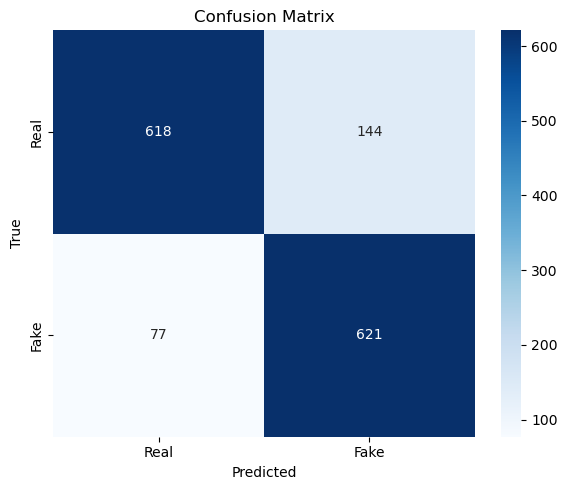

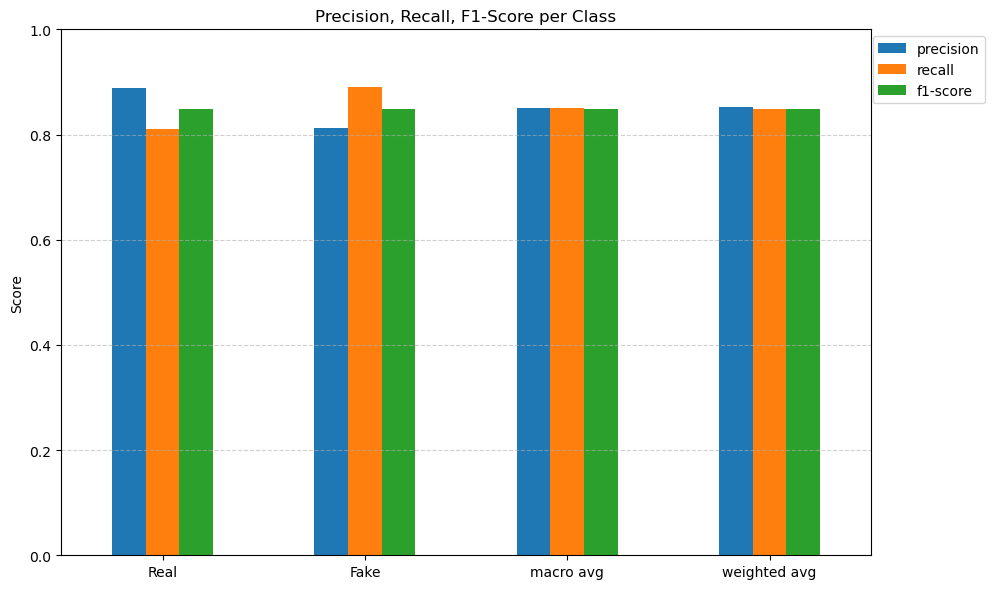

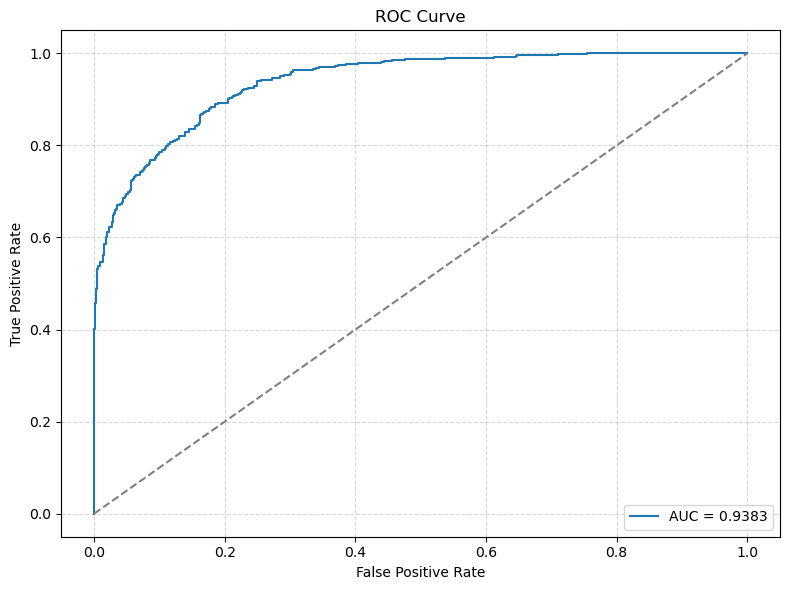

In [65]:
acc, auc, cm, y_true, y_pred, y_probs = evaluate_with_stats(model, test_loader, device=device)
print(f"\nTest Accuracy: {acc:.4f}")
labels=['Real', 'Fake']
plot_confusion_matrix(cm, labels)
plot_classification_report(y_true, y_pred, labels)
plot_roc_curve(y_true, y_probs)

In [69]:
# First, make the prediction on the test dataset
acc, auc, cm, y_true, y_pred, y_probs = evaluate_with_stats(model, test_loader, device=device)

# Create a DataFrame with just predictions and probabilities
pred_df = pd.DataFrame({
    'true_label': y_true,
    'predicted_label': y_pred,
    'probability_fake': y_probs
})

# Reset index of test_df to ensure it matches the order of predictions
test_df_reset = test_df.reset_index(drop=True)

# Make sure pred_df has the same number of rows as test_df_reset
assert len(pred_df) == len(test_df_reset), "Number of predictions doesn't match number of test samples"

# Combine the original test data with predictions
# This will include all columns from the original test data including 
# translated text, domain, and any other columns you have
combined_df = pd.concat([test_df_reset, pred_df], axis=1)

selected_columns = ['translated_text', 'domain'] + [col for col in test_df.columns if col not in ['translated_text', 'domain']]
subset_test_df = test_df_reset[selected_columns]

combined_df = pd.concat([subset_test_df, pred_df], axis=1)

# Save to CSV
combined_df.to_csv('test_predictions_full.csv', index=False)
print("Predictions saved to 'test_predictions_full.csv'")

Evaluating: 100%|██████████████████████████████| 46/46 [00:00<00:00, 347.47it/s]



Accuracy: 0.8486
AUC-ROC: 0.9383
Confusion Matrix:
 [[618 144]
 [ 77 621]]
Predictions saved to 'test_predictions_full.csv'


In [71]:
import pandas as pd

# Define the path to your predictions file
input_csv_path = 'test_predictions_full.csv'
output_csv_path = 'wrong_predictions.csv'

try:
    # Load the DataFrame from the CSV file
    combined_df = pd.read_csv(input_csv_path)

    # --- Verification Step (Important!) ---
    # Ensure the necessary columns exist
    if 'true_label' not in combined_df.columns or 'predicted_label' not in combined_df.columns:
        raise ValueError(f"Error: CSV file '{input_csv_path}' is missing required columns 'true_label' or 'predicted_label'.")

    # Check the data types and unique values to be sure about comparison
    print("Data types:")
    print(combined_df[['true_label', 'predicted_label']].dtypes)
    print("\nUnique values:")
    print(f"  true_label: {combined_df['true_label'].unique()}")
    print(f"  predicted_label: {combined_df['predicted_label'].unique()}")
    # --- End Verification ---

    # Filter rows where the true label is different from the predicted label
    # This directly selects all False Positives and False Negatives
    wrong_predictions_df = combined_df[combined_df['true_label'] != combined_df['predicted_label']].copy() # Use .copy() to avoid SettingWithCopyWarning if modifying later

    # --- Report Results ---
    total_predictions = len(combined_df)
    total_wrong = len(wrong_predictions_df)
    print(f"\nTotal predictions analyzed: {total_predictions}")
    print(f"Number of wrong predictions found (FP + FN): {total_wrong}")

    if total_wrong > 0:

        POSITIVE_CLASS = 1
        NEGATIVE_CLASS = 0
        false_positives = wrong_predictions_df[(wrong_predictions_df['true_label'] == NEGATIVE_CLASS) & (wrong_predictions_df['predicted_label'] == POSITIVE_CLASS)]
        false_negatives = wrong_predictions_df[(wrong_predictions_df['true_label'] == POSITIVE_CLASS) & (wrong_predictions_df['predicted_label'] == NEGATIVE_CLASS)]
        print(f"  - False Positives (Predicted {POSITIVE_CLASS}, True {NEGATIVE_CLASS}): {len(false_positives)}")
        print(f"  - False Negatives (Predicted {NEGATIVE_CLASS}, True {POSITIVE_CLASS}): {len(false_negatives)}")

        # Display the first few wrongly predicted rows
        print("\nFirst 5 wrongly predicted rows:")
        print(wrong_predictions_df.head())

        # Save the wrongly predicted rows to a new CSV file
        wrong_predictions_df.to_csv(output_csv_path, index=False)
        print(f"\nWrongly predicted rows saved to '{output_csv_path}'")
    else:
        print("\nNo wrong predictions found!")

except FileNotFoundError:
    print(f"Error: The file '{input_csv_path}' was not found. Please ensure it's in the correct directory.")
except ValueError as ve:
     print(ve)
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Data types:
true_label         int64
predicted_label    int64
dtype: object

Unique values:
  true_label: [0 1]
  predicted_label: [1 0]

Total predictions analyzed: 1460
Number of wrong predictions found (FP + FN): 221
  - False Positives (Predicted 1, True 0): 144
  - False Negatives (Predicted 0, True 1): 77

First 5 wrongly predicted rows:
                                      translated_text  \
0   DENVER — Voters in one small Colorado town won...   
16  In a darkened and sweltering room in Hackney, ...   
17  A federal appeals court overturned a lower cou...   
25  Trump would later say that what he really want...   
34  Two ‘prolific’ dark web marketplaces have been...   

                          domain  Unnamed: 0  \
0                    nbcnews.com       10199   
16                      vice.com       10248   
17                     slate.com       11852   
25  resistancehole.clickhole.com        7765   
34                     digit.fyi       11038   

                      

### THIS IS WHERE THE ANALYSIS STARTS

In [73]:
#Loading the wrongly predicted samples 
wrong_df = pd.read_csv('wrong_predictions.csv')
print(f"Loaded {len(wrong_df)} wrongly predicted samples.")

Loaded 221 wrongly predicted samples.


Loaded 221 wrongly predicted samples from 'wrong_predictions.csv'.
Extracting and converting BERT embeddings (expected dimension: 768)...
Embeddings seem to be stored as strings. Parsing...
Successfully created embedding matrix with shape: (221, 768)
Detected embedding dimension: 768
Embedding dimension (768) matches expected value.

Calculating inertia for different K values...


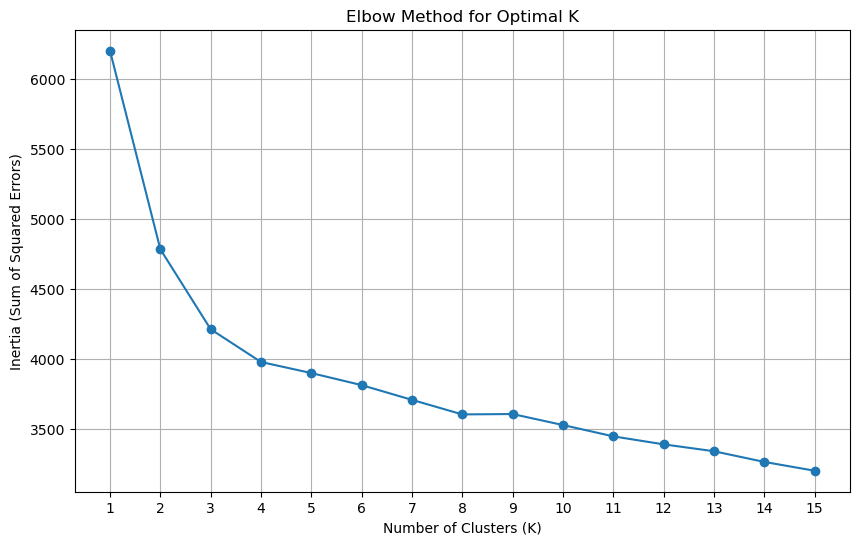

Enter the optimal number of clusters (K) based on the elbow plot (1-15):  4


Selected optimal K = 4

Applying K-Means with K=4...
Assigned all 221 misclassified samples to 4 clusters.

Cluster distribution (for samples with valid embeddings):
cluster
0     42
1    118
2     29
3     32
Name: count, dtype: int64


In [83]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import ast # For safe string parsing if needed

# --- Load Data (Ensure wrong_df is loaded first) ---
try:
    # Define the path if not already loaded
    input_csv_path = 'wrong_predictions.csv'
    wrong_df = pd.read_csv(input_csv_path)
    print(f"Loaded {len(wrong_df)} wrongly predicted samples from '{input_csv_path}'.")

    # --- Extract and Convert Embeddings ---
    print("Extracting and converting BERT embeddings (expected dimension: 768)...")

    # Check if the column exists
    embedding_col = 'bert_embeddings'
    if embedding_col not in wrong_df.columns:
        raise ValueError(f"Column '{embedding_col}' not found in the DataFrame.")

    # Check the type of the first element to decide on conversion method
    # Use .dropna() just in case there are any NaN cells before checking type
    first_valid_embedding = wrong_df[embedding_col].dropna().iloc[0]

    if isinstance(first_valid_embedding, str):
        # If embeddings are stored as string representations of lists (e.g., "[0.1, 0.2, ...]")
        print("Embeddings seem to be stored as strings. Parsing...")
        try:
            # Use ast.literal_eval for safe parsing
            # Handle potential NaNs if any exist after dropping some above
            embeddings_list = [ast.literal_eval(emb_str) if isinstance(emb_str, str) else None
                               for emb_str in wrong_df[embedding_col]]
            # Filter out potential None values if parsing failed for some rows or they were NaN
            valid_embeddings_list = [emb for emb in embeddings_list if emb is not None and len(emb) == 768]
            if len(valid_embeddings_list) != len(embeddings_list):
                 print(f"Warning: Filtered out {len(embeddings_list) - len(valid_embeddings_list)} rows due to parsing errors, NaNs, or incorrect length.")
            misclassified_bert_embeddings = np.array(valid_embeddings_list, dtype=np.float32)

        except (ValueError, SyntaxError) as parse_error:
            print(f"Error parsing string embeddings: {parse_error}")
            print("Please ensure strings are valid list representations of 768 numbers.")
            raise
    elif isinstance(first_valid_embedding, (list, np.ndarray)):
         # If embeddings are already stored as lists or numpy arrays in the cells
        print("Embeddings seem to be stored as lists/arrays. Converting...")
        try:
            # Convert the Series of lists/arrays into a 2D NumPy array
            # Filter for lists/arrays of the correct length (768) and handle potential NaNs
            valid_embeddings = wrong_df[embedding_col].dropna().apply(lambda x: x if len(x) == 768 else None).dropna()
            if len(valid_embeddings) != len(wrong_df):
                 print(f"Warning: Filtered out {len(wrong_df) - len(valid_embeddings)} rows due to NaNs or incorrect embedding length.")
            misclassified_bert_embeddings = np.array(valid_embeddings.tolist(), dtype=np.float32)
            # Keep track of original indices if filtering happened
            # original_indices = valid_embeddings.index

        except Exception as convert_error:
            print(f"Error converting list/array embeddings: {convert_error}")
            raise
    else:
        raise TypeError(f"Unsupported data type found in '{embedding_col}' column: {type(first_valid_embedding)}")

    # --- Verification ---
    if misclassified_bert_embeddings.size == 0:
        raise ValueError("No valid 768-dimensional embeddings found after conversion/filtering.")

    print(f"Successfully created embedding matrix with shape: {misclassified_bert_embeddings.shape}")
    if len(misclassified_bert_embeddings.shape) != 2:
         raise ValueError(f"Converted embeddings are not 2-dimensional! Shape: {misclassified_bert_embeddings.shape}")

    num_samples, embedding_dim = misclassified_bert_embeddings.shape
    # Note: num_samples might be less than len(wrong_df) if filtering occurred

    # Check dimension - User confirmed 768 is correct
    print(f"Detected embedding dimension: {embedding_dim}")
    if embedding_dim != 768:
        # Raise an error because the dimension MUST be 768
        raise ValueError(f"Error: Expected embedding dimension 768, but found {embedding_dim} after conversion. Please check the data in '{embedding_col}'.")
    else:
        print("Embedding dimension (768) matches expected value.")

    # --- Determine Optimal K (Elbow Method) ---
    print("\nCalculating inertia for different K values...")
    sse = [] # Sum of squared errors (inertia)
    # Let's test a reasonable range for K
    max_k = min(15, num_samples) # Cannot have more clusters than samples
    if max_k <= 1:
        raise ValueError("Need at least 2 valid samples to perform clustering.")
    k_range = range(1, max_k + 1)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(misclassified_bert_embeddings)
        sse.append(kmeans.inertia_)

    # Plot the Elbow graph
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, sse, marker='o')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia (Sum of Squared Errors)')
    plt.title('Elbow Method for Optimal K')
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()

    # --- Apply K-Means with Chosen K ---
    k_optimal = 0
    while not (1 <= k_optimal <= max_k):
       try:
           k_optimal = int(input(f"Enter the optimal number of clusters (K) based on the elbow plot (1-{max_k}): "))
       except ValueError:
           print("Invalid input. Please enter an integer.")
    print(f"Selected optimal K = {k_optimal}")

    print(f"\nApplying K-Means with K={k_optimal}...")
    kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(misclassified_bert_embeddings)

    # --- Add cluster labels back to the DataFrame ---
    if num_samples == len(wrong_df):
        wrong_df['cluster'] = cluster_labels
        print(f"Assigned all {len(wrong_df)} misclassified samples to {k_optimal} clusters.")
    else:
        print(f"Warning: Assigning clusters only to the {num_samples} rows with valid embeddings.")
        # Create a temporary series with the right index
        cluster_series = pd.Series(cluster_labels, index=valid_embeddings.index) # Assumes 'valid_embeddings' was created
        wrong_df['cluster'] = cluster_series # Assigns NaN to rows without valid embeddings

    print("\nCluster distribution (for samples with valid embeddings):")
    print(wrong_df['cluster'].value_counts().sort_index()) # Use sort_index for ordered view


except FileNotFoundError:
    print(f"Error: The file '{input_csv_path}' was not found.")
except ValueError as ve:
    print(f"ValueError: {ve}")
except TypeError as te:
    print(f"TypeError: {te}")
except Exception as e:
    print(f"An unexpected error occurred during clustering phase: {e}")
    raise # Re-raise for debugging

In [85]:
import nltk

print("Checking for NLTK resources...")

# --- Check and download 'stopwords' ---
try:
    # Try to find the resource
    nltk.data.find('corpora/stopwords')
    print("- 'stopwords' resource found.")
except LookupError:
    # If not found, download it
    print("- 'stopwords' resource not found. Downloading...")
    nltk.download('stopwords', quiet=True) # Use quiet=True to suppress excessive download output
    print("- 'stopwords' resource downloaded.")
except Exception as e:
    print(f"An unexpected error occurred checking/downloading 'stopwords': {e}")

# --- Check and download 'punkt' (for tokenization) ---
try:
    # Try to find the resource
    nltk.data.find('tokenizers/punkt')
    print("- 'punkt' resource found.")
except LookupError:
    # If not found, download it
    print("- 'punkt' resource not found. Downloading...")
    nltk.download('punkt', quiet=True)
    print("- 'punkt' resource downloaded.")
except Exception as e:
    print(f"An unexpected error occurred checking/downloading 'punkt': {e}")

print("NLTK resource check complete.")

Checking for NLTK resources...
- 'stopwords' resource found.
- 'punkt' resource found.
NLTK resource check complete.


In [87]:
import pandas as pd
import numpy as np
import re
from collections import Counter

# --- Text Processing ---
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# --- Data Visualization (Optional but Recommended) ---
import matplotlib.pyplot as plt
import seaborn as sns

# Define the number of clusters determined previously
k_optimal = 5

# --- Basic Text Preprocessing Function ---
# Get English stopwords
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):
        return "" # Return empty string for non-string inputs (like NaN)
    text = text.lower() # Lowercase
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    text = re.sub(r'\d+', '', text) # Remove numbers
    tokens = word_tokenize(text) # Tokenize
    # Remove stopwords and short tokens
    processed_tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return " ".join(processed_tokens)

# --- Analyze Each Cluster ---

print("\n--- Starting Phase 3: Cluster Analysis ---")

# Handle potential NaN clusters if filtering occurred in Phase 2
if wrong_df['cluster'].isnull().any():
    print("Note: Found rows with NaN cluster assignment (likely due to invalid embeddings). Analyzing only rows with valid clusters.")
    analysis_df = wrong_df.dropna(subset=['cluster']).copy()
    # Convert cluster column to integer type after dropping NaNs
    analysis_df['cluster'] = analysis_df['cluster'].astype(int)
else:
    analysis_df = wrong_df.copy()
    # Ensure cluster column is integer type
    analysis_df['cluster'] = analysis_df['cluster'].astype(int)


# Preprocess text for all samples once (more efficient)
print("Preprocessing text for NLP analysis...")
analysis_df['processed_text'] = analysis_df['translated_text'].apply(preprocess_text)
print("Text preprocessing complete.")


# --- Loop through each cluster ---
for cluster_id in range(k_optimal):
    print(f"\n===== Analyzing Cluster {cluster_id} =====")

    # Isolate data for the current cluster
    cluster_df = analysis_df[analysis_df['cluster'] == cluster_id]
    num_samples_in_cluster = len(cluster_df)

    if num_samples_in_cluster == 0:
        print("Cluster is empty. Skipping.")
        continue

    print(f"Number of samples in cluster: {num_samples_in_cluster}")

    # --- 1. NLP Analysis ---
    print("\n--- NLP Analysis ---")
    cluster_texts = cluster_df['processed_text'].tolist()

    # a) Most Frequent Words (using CountVectorizer for simplicity)
    try:
        vectorizer_count = CountVectorizer(max_features=10) # Get top 10 frequent words
        vectorizer_count.fit(cluster_texts)
        top_words = vectorizer_count.get_feature_names_out()
        print(f"Top {len(top_words)} Frequent Words: {', '.join(top_words)}")
    except ValueError:
        print("Could not determine frequent words (perhaps too little text).")


    # b) Top TF-IDF Words (characteristic words within this cluster)
    try:
        vectorizer_tfidf = TfidfVectorizer(max_features=10) # Top 10 characteristic words
        vectorizer_tfidf.fit(cluster_texts) # Fit only on this cluster's text
        top_tfidf_words = vectorizer_tfidf.get_feature_names_out()
        print(f"Top {len(top_tfidf_words)} TF-IDF Words: {', '.join(top_tfidf_words)}")
    except ValueError:
         print("Could not determine TF-IDF words (perhaps too little text).")


    # --- 2. Other Feature Analysis ---
    print("\n--- Other Feature Analysis ---")

    # a) Numeric Features (Example: readability, sentiment, probability)
    numeric_cols = ['readability_features', 'sentiment_features', 'ela_features', 'probability_fake']
    # Filter for numeric columns that actually exist in the DataFrame
    available_numeric_cols = [col for col in numeric_cols if col in cluster_df.columns]
    if available_numeric_cols:
        print("Numeric Feature Summary:")
        print(cluster_df[available_numeric_cols].describe())
    else:
        print("No standard numeric features found for analysis.")


    # b) Categorical Features (Example: domain)
    categorical_cols = ['domain']
    available_categorical_cols = [col for col in categorical_cols if col in cluster_df.columns]
    if available_categorical_cols:
        for col in available_categorical_cols:
             print(f"\n'{col}' Distribution:")
             # Show top 5 most common values
             print(cluster_df[col].value_counts().head(5))
    else:
        print("No standard categorical features found for analysis.")

    # c) Prediction Analysis (FP/FN Ratio)
    # Assuming 1 = Positive (Fake), 0 = Negative (Real) - Adjust if needed
    POSITIVE_CLASS = 1
    NEGATIVE_CLASS = 0
    if 'true_label' in cluster_df.columns and 'predicted_label' in cluster_df.columns:
        fp = ((cluster_df['true_label'] == NEGATIVE_CLASS) & (cluster_df['predicted_label'] == POSITIVE_CLASS)).sum()
        fn = ((cluster_df['true_label'] == POSITIVE_CLASS) & (cluster_df['predicted_label'] == NEGATIVE_CLASS)).sum()
        print(f"\nPrediction Errors in Cluster:")
        print(f"  False Positives (Predicted Fake, True Real): {fp} ({fp/num_samples_in_cluster:.1%})")
        print(f"  False Negatives (Predicted Real, True Fake): {fn} ({fn/num_samples_in_cluster:.1%})")
    else:
        print("\n'true_label' or 'predicted_label' columns not found for FP/FN analysis.")


    # --- 3. Qualitative Analysis ---
    print("\n--- Qualitative Examples (First 3 Samples) ---")
    # Display relevant columns for a few samples
    relevant_cols = ['translated_text', 'true_label', 'predicted_label', 'probability_fake'] + available_numeric_cols + available_categorical_cols
    # Ensure columns exist before trying to display them
    display_cols = [col for col in relevant_cols if col in cluster_df.columns]
    pd.set_option('display.max_colwidth', 200) # Display more text
    print(cluster_df[display_cols].head(3))


print("\n===== Cluster Analysis Complete =====")
# Reset display option if needed
pd.reset_option('display.max_colwidth')


--- Starting Phase 3: Cluster Analysis ---
Preprocessing text for NLP analysis...
Text preprocessing complete.

===== Analyzing Cluster 0 =====
Number of samples in cluster: 42

--- NLP Analysis ---
Top 10 Frequent Words: also, canada, marijuana, new, one, police, said, time, trump, would
Top 10 TF-IDF Words: also, canada, marijuana, new, one, police, said, time, trump, would

--- Other Feature Analysis ---
Numeric Feature Summary:
       probability_fake
count         42.000000
mean           0.542355
std            0.263710
min            0.017254
25%            0.408849
50%            0.570585
75%            0.728988
max            0.981725

'domain' Distribution:
domain
nytimes.com     6
theonion.com    4
bbc.com         3
smh.com.au      1
genius.com      1
Name: count, dtype: int64

Prediction Errors in Cluster:
  False Positives (Predicted Fake, True Real): 28 (66.7%)
  False Negatives (Predicted Real, True Fake): 14 (33.3%)

--- Qualitative Examples (First 3 Samples) ---
     

In [79]:
# List of columns you want to keep
selected_columns = ['domain', 'title', 'translated_text', 'true_label', 'predicted_label' , 'cluster']

# Create the new DataFrame by selecting only these columns from wrong_df
# Make sure 'wrong_df' actually has these columns first!
try:
    wrong_df_selected = wrong_df[selected_columns].copy() 

    print("Selected DataFrame preview:")
    print(wrong_df_selected.head())

except KeyError as e:
    print(f"Error: Column '{e}' not found in the DataFrame.")
    print("Please ensure 'wrong_df' contains all the specified columns:")
    print(selected_columns)
    print("\nAvailable columns:", list(wrong_df.columns))

except NameError:
     print("Error: DataFrame named 'wrong_df' not found.")
     print("Please make sure you have loaded or created the DataFrame correctly.")

output_filename_selected = 'wrong_predictions_selected_columns.csv'

try:
    print(f"Saving the selected columns DataFrame to '{output_filename_selected}'...")
    # Use the .to_csv() method on the DataFrame you created
    wrong_df_selected.to_csv(output_filename_selected, index=False) 
    print("Selected DataFrame saved successfully.")

except NameError:
     print("Error: DataFrame named 'wrong_df_selected' not found.")
     print("Please make sure you ran the code to select the columns first.")
except Exception as e:
     print(f"An error occurred while saving the file: {e}")
# -------------------------------------------------------

Selected DataFrame preview:
                         domain  \
0                   nbcnews.com   
1                      vice.com   
2                     slate.com   
3  resistancehole.clickhole.com   
4                     digit.fyi   

                                               title  \
0         Marksmen line up for drone-hunting permits   
1  This Nightclub for the Elderly Is Fighting Lon...   
2  Court: Hitting “Like” on Facebook Protected by...   
3  How Donald Trump Beat Palm Beach Society and W...   
4  Dark Web Marketplaces Shut Down Following Poli...   

                                     translated_text  true_label  \
0  DENVER — Voters in one small Colorado town won...           0   
1  In a darkened and sweltering room in Hackney, ...           0   
2  A federal appeals court overturned a lower cou...           0   
3  Trump would later say that what he really want...           1   
4  Two ‘prolific’ dark web marketplaces have been...           0   

   predicted_la

In [81]:
import pandas as pd

# Specify the path to your CSV file
input_csv_path = 'test_predictions_full.csv' 

# --- Set pandas display options to show all rows ---
pd.set_option('display.max_rows', None) # Show all rows
pd.set_option('display.max_columns', None) # Show all columns (optional, but good practice)
pd.set_option('display.width', 1000) # Set a wider display area (optional, helps prevent line wrapping)
# -----------------------------------------------------

try:
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(input_csv_path)

    # --- 1. Frequency count of each domain ---
    # Note: value_counts is already sorted descending by default
    print("--- Domain Frequency Counts ---")
    domain_counts = df['domain'].value_counts()
    print(domain_counts)
    print("-" * 30) # Separator

    # --- 2. Percentage of mismatch (true_label != predicted_label) per domain ---
    print("\n--- Mismatch Percentage per Domain (Sorted by Mismatch Count Descending) ---")
    
    # Calculate mismatch count per domain
    df['mismatch'] = df['true_label'] != df['predicted_label'] 
    
    # Group by domain and calculate the sum and total count
    mismatch_analysis = df.groupby('domain').agg(
        total_count=('domain', 'size'),
        mismatch_count=('mismatch', 'sum')
    )
    
    # Calculate the mismatch percentage
    mismatch_analysis['mismatch_percentage'] = (mismatch_analysis['mismatch_count'] / mismatch_analysis['total_count']) * 100
    
    # --- Sort the results by mismatch_count in descending order ---
    mismatch_analysis_sorted = mismatch_analysis.sort_values(by='mismatch_count', ascending=False)
    # ---------------------------------------------------------------
    
    # Select and display the relevant columns from the sorted DataFrame
    print(mismatch_analysis_sorted[['total_count', 'mismatch_count', 'mismatch_percentage']])
    print("-" * 30) # Separator

except FileNotFoundError:
    print(f"Error: The file '{input_csv_path}' was not found.")
    print("Please make sure the file exists and the path is correct.")
except KeyError as e:
    print(f"Error: Column '{e}' not found in the CSV file.")
    print("Please ensure your CSV has the columns 'domain', 'true_label', and 'predicted_label'.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Domain Frequency Counts ---
domain
weibo.com                       642
theonion.com                    109
clickhole.com                    75
waterfordwhispersnews.com        32
theguardian.com                  21
bbc.com                          19
bbc.co.uk                        18
people.com                       14
cnn.com                          13
nytimes.com                      13
politics.theonion.com            12
nbcnews.com                      11
local.theonion.com               11
independent.co.uk                10
foxnews.com                       9
abcnews.go.com                    9
huffingtonpost.com                8
archive.is                        7
www.dailymail.co.uk               6
youtu.be                          6
news.yahoo.com                    6
sports.theonion.com               5
time.com                          5
buzzfeed.com                      5
economist.com                     5
nydailynews.com                   5
www.etonline.com         